# IRIS(붓꽃) Classification

## 필요 패키지 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm, notebook

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torch.cuda.is_available())
print(DEVICE)

1.10.1
True
cuda


## 데이터 살펴보기

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
# Feature와 Label로 구분
X = data['data']
Y = data['target']
label_name = data['target_names']
n_classes = max(Y)+1

print(X[:5])
print(Y[:5])
print(label_name)
print(n_classes)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]
['setosa' 'versicolor' 'virginica']
3


In [4]:
# Y값 one_Hot Encoding
n = np.unique(Y, axis=0).shape[0]
Y = np.eye(n)[Y]

print(Y.shape)

(150, 3)


In [5]:
# Train, Valid Dataset 분리
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(X, Y, stratify = Y, random_state = 17, test_size = 0.15)
print("Train Feature Shape : {}".format(train_x.shape))
print("Train Label Shape : {}".format(train_y.shape))
print("Valid Feature Shape : {}".format(valid_x.shape))
print("Valid Label Shape : {}".format(valid_y.shape))

Train Feature Shape : (127, 4)
Train Label Shape : (127, 3)
Valid Feature Shape : (23, 4)
Valid Label Shape : (23, 3)


In [6]:
# array to Tensor
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
valid_x = torch.tensor(valid_x)
valid_y = torch.tensor(valid_y)

print("Train Feature Shape : {}".format(train_x.shape))
print("Train Label Shape : {}".format(train_y.shape))
print("Valid Feature Shape : {}".format(valid_x.shape))
print("Valid Label Shape : {}".format(valid_y.shape))

Train Feature Shape : torch.Size([127, 4])
Train Label Shape : torch.Size([127, 3])
Valid Feature Shape : torch.Size([23, 4])
Valid Label Shape : torch.Size([23, 3])


## Dataset 정의

In [7]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x = x_data
        self.y = y_data
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        xx = self.x[idx].float()
        yy = self.y[idx].float()
        return xx, yy
    
train = MyDataset(train_x, train_y)
valid = MyDataset(valid_x, valid_y)

train_loader = DataLoader(train, batch_size = 4, shuffle=True)
valid_loader = DataLoader(valid, batch_size = 2)

print(train_loader)
print(valid_loader)

## 훈련 & 검증 함수 정의

In [8]:
loss_fn = nn.CrossEntropyLoss()

def calc_acc(X, Y):
    x_val, x_idx = torch.max(X, dim=1)
    y_val, y_idx = torch.max(Y, dim=1)
    return (x_idx == y_idx).sum().item()

def train(EPOCHS, model, train_loader, valid_loader, opt):
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    for epoch in range(1, EPOCHS+1):
        model.train()
        train_acc = 0
        print("<<< EPOCH {} >>>".format(epoch))
        for batch_idx, (x,y) in enumerate(notebook.tqdm(train_loader)):
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            output = model(x)                 # 순전파
            loss = loss_fn(output, y)         # 오차 계산

            opt.zero_grad()                   # opt내부 값 초기화
            loss.backward()                   # 오차 역전파
            opt.step()                        # 가중치 갱신
            
            train_acc += calc_acc(output, y)
            if batch_idx % 10 == 0 and batch_idx != 0:
                print("Training : [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Acc : {:.3f}".format(
                    batch_idx * len(x), 
                    len(train_loader.dataset), 
                    100. * batch_idx / len(train_loader), 
                    loss.item(),
                    train_acc / len(train_loader.dataset)))
        print("\n{} Training : Loss: {:.6f}\t Acc : {:.3f}".format(
                    epoch,  
                    loss.item(),
                    train_acc / len(train_loader.dataset)))
        
        t_loss, t_acc = evaluate(model, valid_loader)
        print("{} Validation : Loss : {:.4f}\t Acc: {:.2f}%\n\n\n".format(epoch, t_loss, t_acc*100.))

        train_loss_history.append(loss.item())
        train_acc_history.append(train_acc / len(train_loader.dataset))

        valid_loss_history.append(t_loss.item())
        valid_acc_history.append(t_acc)

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history
                
def evaluate(model, valid_loader):
    model.eval()
    t_loss = 0
    correct = 0
    
    with torch.no_grad():
        for x, y in notebook.tqdm(valid_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            output = model(x)
            t_loss += loss_fn(output, y)
            
            correct += calc_acc(output, y)

    t_loss /= len(valid_loader)
    t_acc = correct / len(valid_loader.dataset)
    return t_loss, t_acc

## 모델 정의

In [9]:
class MyModel1(nn.Module):
    def __init__(self):
        super(MyModel1, self).__init__()
        
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, n_classes)
        
        self.act_fn = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        
        x = self.fc2(x)
        x = self.act_fn(x)
        
        x = self.fc3(x)
        return x

In [10]:
class MyModel2(nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__()
        
        self.fc1 = nn.Linear(4, 16*4)
        
        self.Q = nn.Linear(16, 8)
        self.K = nn.Linear(16, 8)
        self.V = nn.Linear(16, 8)
        
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, n_classes)
        
        self.act_fn = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        
        x = x.view(-1, 4, 16)
        
        q = self.Q(x) # (batch, 4, 8)
        k = self.K(x) # (batch, 4, 8)
        v = self.V(x) # (batch, 4, 8)
        
        score = torch.matmul(q, torch.transpose(k, 1, 2)) # (batch, 4, 16)
        score = self.softmax(score) / np.sqrt(8)         # (batch, 4, 16)
        
        z = torch.matmul(score, v) # (batch, 4, 8)
        z = z.view(-1, 4*8)
        
        x = self.fc2(z)
        x = self.act_fn(x)
        
        x = self.fc3(x)
        return x

## 모델 학습 및 성능 검증

## 단순 선형회귀

In [11]:
model = MyModel1().to(DEVICE)
opt = optim.Adam(model.parameters())

print("Model :",model)
print("model's number of Parameters: ", sum([p.numel() for p in model.parameters()]))

Model : MyModel1(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (act_fn): ReLU()
)
model's number of Parameters:  243


In [12]:
t_loss_his, t_acc_his, v_loss_his, v_acc_his = train(EPOCHS = 10, model = model, train_loader = train_loader, valid_loader = valid_loader, opt = opt)

<<< EPOCH 1 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 1.046869	 Acc : 0.189
Training : [80/127 (62%)]	Loss: 1.130223	 Acc : 0.276
Training : [120/127 (94%)]	Loss: 1.117985	 Acc : 0.370

1 Training : Loss: 1.069064	 Acc : 0.378


  0%|          | 0/12 [00:00<?, ?it/s]

1 Validation : Loss : 1.0696	 Acc: 30.43%



<<< EPOCH 2 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 1.101946	 Acc : 0.094
Training : [80/127 (62%)]	Loss: 1.070963	 Acc : 0.205
Training : [120/127 (94%)]	Loss: 0.989257	 Acc : 0.323

2 Training : Loss: 0.992205	 Acc : 0.339


  0%|          | 0/12 [00:00<?, ?it/s]

2 Validation : Loss : 1.0526	 Acc: 30.43%



<<< EPOCH 3 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 1.052973	 Acc : 0.102
Training : [80/127 (62%)]	Loss: 1.046572	 Acc : 0.205
Training : [120/127 (94%)]	Loss: 1.035451	 Acc : 0.331

3 Training : Loss: 1.024177	 Acc : 0.339


  0%|          | 0/12 [00:00<?, ?it/s]

3 Validation : Loss : 1.0330	 Acc: 30.43%



<<< EPOCH 4 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 1.043535	 Acc : 0.118
Training : [80/127 (62%)]	Loss: 0.915214	 Acc : 0.205
Training : [120/127 (94%)]	Loss: 0.882705	 Acc : 0.339

4 Training : Loss: 0.908218	 Acc : 0.354


  0%|          | 0/12 [00:00<?, ?it/s]

4 Validation : Loss : 1.0039	 Acc: 34.78%



<<< EPOCH 5 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.927398	 Acc : 0.150
Training : [80/127 (62%)]	Loss: 0.855122	 Acc : 0.291
Training : [120/127 (94%)]	Loss: 0.991866	 Acc : 0.441

5 Training : Loss: 1.073041	 Acc : 0.449


  0%|          | 0/12 [00:00<?, ?it/s]

5 Validation : Loss : 0.9718	 Acc: 56.52%



<<< EPOCH 6 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.806549	 Acc : 0.268
Training : [80/127 (62%)]	Loss: 0.933075	 Acc : 0.441
Training : [120/127 (94%)]	Loss: 0.978890	 Acc : 0.646

6 Training : Loss: 0.859639	 Acc : 0.669


  0%|          | 0/12 [00:00<?, ?it/s]

6 Validation : Loss : 0.9080	 Acc: 65.22%



<<< EPOCH 7 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.963439	 Acc : 0.244
Training : [80/127 (62%)]	Loss: 0.802488	 Acc : 0.457
Training : [120/127 (94%)]	Loss: 0.787190	 Acc : 0.669

7 Training : Loss: 1.053189	 Acc : 0.669


  0%|          | 0/12 [00:00<?, ?it/s]

7 Validation : Loss : 0.8292	 Acc: 65.22%



<<< EPOCH 8 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.684191	 Acc : 0.228
Training : [80/127 (62%)]	Loss: 0.915533	 Acc : 0.402
Training : [120/127 (94%)]	Loss: 0.598772	 Acc : 0.661

8 Training : Loss: 0.865083	 Acc : 0.669


  0%|          | 0/12 [00:00<?, ?it/s]

8 Validation : Loss : 0.7457	 Acc: 65.22%



<<< EPOCH 9 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.802042	 Acc : 0.205
Training : [80/127 (62%)]	Loss: 0.774793	 Acc : 0.457
Training : [120/127 (94%)]	Loss: 0.491868	 Acc : 0.661

9 Training : Loss: 0.822680	 Acc : 0.669


  0%|          | 0/12 [00:00<?, ?it/s]

9 Validation : Loss : 0.6623	 Acc: 65.22%



<<< EPOCH 10 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.847679	 Acc : 0.205
Training : [80/127 (62%)]	Loss: 0.639355	 Acc : 0.417
Training : [120/127 (94%)]	Loss: 0.595597	 Acc : 0.654

10 Training : Loss: 0.383359	 Acc : 0.677


  0%|          | 0/12 [00:00<?, ?it/s]

10 Validation : Loss : 0.5935	 Acc: 65.22%





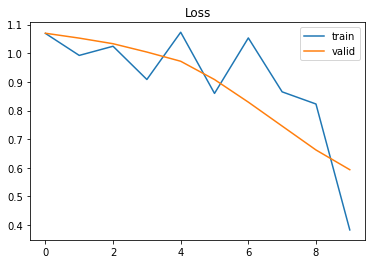

In [13]:
plt.plot(t_loss_his, label="train")
plt.plot(v_loss_his, label="valid")
plt.legend()
plt.title("Loss")
plt.show()

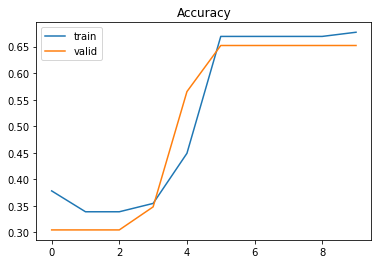

In [14]:
plt.plot(t_acc_his, label="train")
plt.plot(v_acc_his, label="valid")
plt.legend()
plt.title("Accuracy")
plt.show()

## 셀프 어텐션 적용 모델

In [15]:
model = MyModel2().to(DEVICE)
opt = optim.Adam(model.parameters())

print("Model :",model)
print("model's number of Parameters: ", sum([p.numel() for p in model.parameters()]))

Model : MyModel2(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (Q): Linear(in_features=16, out_features=8, bias=True)
  (K): Linear(in_features=16, out_features=8, bias=True)
  (V): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (act_fn): ReLU()
  (softmax): Softmax(dim=-1)
)
model's number of Parameters:  1019


In [16]:
t_loss_his, t_acc_his, v_loss_his, v_acc_his = train(EPOCHS = 10, model = model, train_loader = train_loader, valid_loader = valid_loader, opt = opt)

<<< EPOCH 1 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 1.113500	 Acc : 0.102
Training : [80/127 (62%)]	Loss: 1.031586	 Acc : 0.189
Training : [120/127 (94%)]	Loss: 1.065747	 Acc : 0.323

1 Training : Loss: 0.859659	 Acc : 0.339


  0%|          | 0/12 [00:00<?, ?it/s]

1 Validation : Loss : 1.0244	 Acc: 30.43%



<<< EPOCH 2 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 1.127708	 Acc : 0.142
Training : [80/127 (62%)]	Loss: 0.841290	 Acc : 0.276
Training : [120/127 (94%)]	Loss: 1.086602	 Acc : 0.472

2 Training : Loss: 0.887653	 Acc : 0.496


  0%|          | 0/12 [00:00<?, ?it/s]

2 Validation : Loss : 0.8946	 Acc: 65.22%



<<< EPOCH 3 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.756816	 Acc : 0.236
Training : [80/127 (62%)]	Loss: 0.841800	 Acc : 0.425
Training : [120/127 (94%)]	Loss: 0.844786	 Acc : 0.654

3 Training : Loss: 0.693494	 Acc : 0.669


  0%|          | 0/12 [00:00<?, ?it/s]

3 Validation : Loss : 0.7153	 Acc: 65.22%



<<< EPOCH 4 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.723252	 Acc : 0.252
Training : [80/127 (62%)]	Loss: 0.442060	 Acc : 0.472
Training : [120/127 (94%)]	Loss: 0.399009	 Acc : 0.732

4 Training : Loss: 1.111530	 Acc : 0.732


  0%|          | 0/12 [00:00<?, ?it/s]

4 Validation : Loss : 0.4725	 Acc: 82.61%



<<< EPOCH 5 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.575504	 Acc : 0.323
Training : [80/127 (62%)]	Loss: 0.390208	 Acc : 0.622
Training : [120/127 (94%)]	Loss: 0.219252	 Acc : 0.921

5 Training : Loss: 0.325798	 Acc : 0.945


  0%|          | 0/12 [00:00<?, ?it/s]

5 Validation : Loss : 0.2406	 Acc: 100.00%



<<< EPOCH 6 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.395101	 Acc : 0.331
Training : [80/127 (62%)]	Loss: 0.076219	 Acc : 0.622
Training : [120/127 (94%)]	Loss: 0.086285	 Acc : 0.937

6 Training : Loss: 0.196019	 Acc : 0.961


  0%|          | 0/12 [00:00<?, ?it/s]

6 Validation : Loss : 0.2022	 Acc: 91.30%



<<< EPOCH 7 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.098364	 Acc : 0.339
Training : [80/127 (62%)]	Loss: 0.107942	 Acc : 0.638
Training : [120/127 (94%)]	Loss: 0.075968	 Acc : 0.937

7 Training : Loss: 0.048186	 Acc : 0.961


  0%|          | 0/12 [00:00<?, ?it/s]

7 Validation : Loss : 0.1665	 Acc: 91.30%



<<< EPOCH 8 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.037399	 Acc : 0.323
Training : [80/127 (62%)]	Loss: 0.051439	 Acc : 0.606
Training : [120/127 (94%)]	Loss: 0.297479	 Acc : 0.906

8 Training : Loss: 0.087844	 Acc : 0.929


  0%|          | 0/12 [00:00<?, ?it/s]

8 Validation : Loss : 0.0917	 Acc: 100.00%



<<< EPOCH 9 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.060780	 Acc : 0.315
Training : [80/127 (62%)]	Loss: 0.543211	 Acc : 0.614
Training : [120/127 (94%)]	Loss: 0.054991	 Acc : 0.921

9 Training : Loss: 0.023854	 Acc : 0.945


  0%|          | 0/12 [00:00<?, ?it/s]

9 Validation : Loss : 0.0623	 Acc: 100.00%



<<< EPOCH 10 >>>


  0%|          | 0/32 [00:00<?, ?it/s]

Training : [40/127 (31%)]	Loss: 0.153605	 Acc : 0.315
Training : [80/127 (62%)]	Loss: 0.285837	 Acc : 0.598
Training : [120/127 (94%)]	Loss: 0.031138	 Acc : 0.898

10 Training : Loss: 0.043692	 Acc : 0.921


  0%|          | 0/12 [00:00<?, ?it/s]

10 Validation : Loss : 0.0581	 Acc: 100.00%





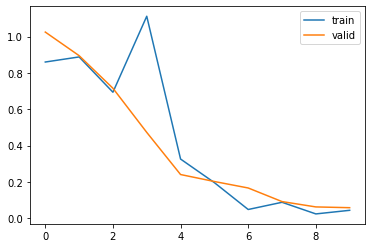

In [17]:
plt.plot(t_loss_his, label="train")
plt.plot(v_loss_his, label="valid")
plt.legend()
plt.show()

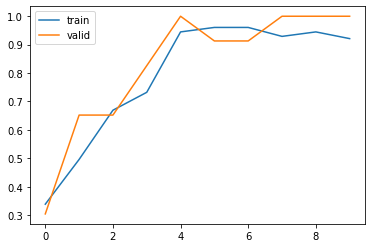

In [18]:
plt.plot(t_acc_his, label="train")
plt.plot(v_acc_his, label="valid")
plt.legend()
plt.show()